Genre counts:
 genres_list
Drama                 4361
Comedy                3756
Thriller              1894
Action                1828
Romance               1596
Adventure             1263
Crime                 1199
Sci-Fi                 980
Horror                 978
Fantasy                779
Children               664
Animation              611
Mystery                573
Documentary            440
War                    382
Musical                334
Western                167
IMAX                   158
Film-Noir               87
(no genres listed)      34
Name: count, dtype: int64


/var/folders/g7/ckk2ycjx2cv7qv6k9jx0kh8w0000gn/T/ipykernel_12690/588786844.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette="viridis")


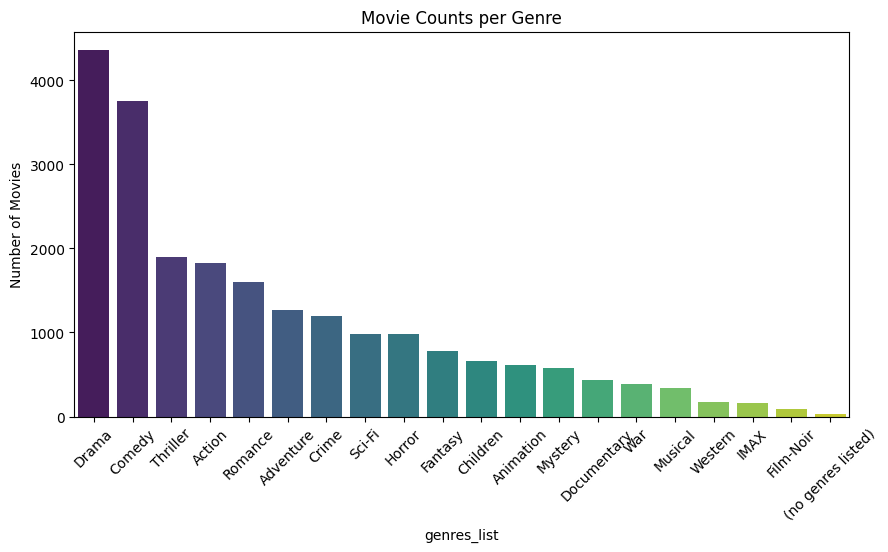

In [2]:
import pandas as pd

# Set your path to the movies CSV
movies = pd.read_csv("movies.csv")

# Split genres into lists
movies['genres_list'] = movies['genres'].str.split('|')

# Flatten all genres into a single series
all_genres = movies['genres_list'].explode()

# Count occurrences per genre
genre_counts = all_genres.value_counts()

# Display
print("Genre counts:\n", genre_counts)

# Optional: plot a simple bar chart
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette="viridis")
plt.xticks(rotation=45)
plt.ylabel("Number of Movies")
plt.title("Movie Counts per Genre")
plt.show()


In [3]:
import pandas as pd

# Load the CSVs
ratings = pd.read_csv("ratings.csv")
movies = pd.read_csv("movies.csv")

# Compute average rating and number of ratings per movie
movie_stats = ratings.groupby('movieId').agg(
    avg_rating=('rating', 'mean'),
    num_ratings=('rating', 'count')
).reset_index()

# Merge with movie titles
movie_stats = movie_stats.merge(movies[['movieId', 'title']], on='movieId')

# Sort by highest average rating, only include movies with >= 50 ratings
top_movies = movie_stats[movie_stats['num_ratings'] >= 50].sort_values(
    by='avg_rating', ascending=False
).head(20)

# Display
top_movies[['title', 'avg_rating', 'num_ratings']]


,title,avg_rating,num_ratings
277,"Shawshank Redemption, The (1994)",4.429022,317
659,"Godfather, The (1972)",4.289062,192
2224,Fight Club (1999),4.272936,218
974,Cool Hand Luke (1967),4.271930,57
602,Dr. Strangelove or: How I Learned to Stop Worr...,4.268041,97
686,Rear Window (1954),4.261905,84
921,"Godfather: Part II, The (1974)",4.259690,129
6298,"Departed, The (2006)",4.252336,107
913,Goodfellas (1990),4.250000,126
694,Casablanca (1942),4.240000,100


In [4]:
import pandas as pd
import requests
import time
import json

# Load movies and links
top_movies = pd.read_csv("movies.csv")  
links = pd.read_csv("links.csv")

# Merge to get IMDb IDs
top_movies = top_movies.merge(links[['movieId', 'imdbId']], on='movieId', how='left')

# OMDb API key
API_KEY = "4e193ddc"

# Function to safely fetch OMDb data with retries
def fetch_omdb_data_safe(imdb_id, retries=3, delay=1):
    url = f"http://www.omdbapi.com/?i=tt{str(imdb_id).zfill(7)}&apikey={API_KEY}"
    for attempt in range(retries):
        try:
            response = requests.get(url, timeout=5)
            response.raise_for_status()
            data = response.json()
            if data.get("Response") == "False":
                return None
            return {
                "title": data.get("Title"),
                "director": data.get("Director"),
                "actors": data.get("Actors"),  # comma-separated
                "poster": data.get("Poster")
            }
        except requests.exceptions.RequestException as e:
            print(f"Attempt {attempt+1} failed for IMDb {imdb_id}: {e}")
            time.sleep(delay)
    return None

# Progressive enrichment with small batches
enrichment_data = []

batch_size = 50  # process 50 movies at a time
for start in range(0, len(top_movies), batch_size):
    end = start + batch_size
    batch = top_movies.iloc[start:end]
    print(f"Processing movies {start+1} to {min(end, len(top_movies))}")
    
    for idx, row in batch.iterrows():
        imdb_id = row['imdbId']
        info = fetch_omdb_data_safe(imdb_id)
        if info:
            enrichment_data.append(info)
        time.sleep(0.2)  # small delay to avoid API rate limit
    
    # Save partial results after each batch
    with open(f"movie_enrichment_part_{start//batch_size + 1}.json", "w") as f:
        json.dump(enrichment_data, f, indent=2)

# Quick preview
df_enriched = pd.DataFrame(enrichment_data)
df_enriched['top_actors'] = df_enriched['actors'].str.split(',').apply(lambda x: x[:3] if x else [])
df_enriched.head()


Processing movies 1 to 50
Attempt 1 failed for IMDb 114709: 401 Client Error: Unauthorized for url: http://www.omdbapi.com/?i=tt0114709&apikey=4e193ddc
Attempt 2 failed for IMDb 114709: 401 Client Error: Unauthorized for url: http://www.omdbapi.com/?i=tt0114709&apikey=4e193ddc
Attempt 3 failed for IMDb 114709: 401 Client Error: Unauthorized for url: http://www.omdbapi.com/?i=tt0114709&apikey=4e193ddc
Attempt 1 failed for IMDb 113497: 401 Client Error: Unauthorized for url: http://www.omdbapi.com/?i=tt0113497&apikey=4e193ddc
Attempt 2 failed for IMDb 113497: 401 Client Error: Unauthorized for url: http://www.omdbapi.com/?i=tt0113497&apikey=4e193ddc
Attempt 3 failed for IMDb 113497: 401 Client Error: Unauthorized for url: http://www.omdbapi.com/?i=tt0113497&apikey=4e193ddc
Attempt 1 failed for IMDb 113228: 401 Client Error: Unauthorized for url: http://www.omdbapi.com/?i=tt0113228&apikey=4e193ddc
Attempt 2 failed for IMDb 113228: 401 Client Error: Unauthorized for url: http://www.omdbapi

KeyboardInterrupt: 

In [6]:
import pandas as pd
import numpy as np

ratings = pd.read_csv("ratings.csv")
movies = pd.read_csv("movies.csv")
links = pd.read_csv("links.csv")
tags = pd.read_csv("tags.csv")


In [7]:
print("Row counts:")
print(f"Ratings: {len(ratings)}")
print(f"Movies: {len(movies)}")
print(f"Links: {len(links)}")
print(f"Tags: {len(tags)}")


Row counts:
Ratings: 100836
Movies: 9742
Links: 9742
Tags: 3683


In [8]:
print("\nMissing values per table:\n")

print("Ratings")
print(ratings.isnull().sum())
print()

print("Movies")
print(movies.isnull().sum())
print()

print("Links")
print(links.isnull().sum())
print()

print("Tags")
print(tags.isnull().sum())



Missing values per table:

Ratings
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Movies
movieId    0
title      0
genres     0
dtype: int64

Links
movieId    0
imdbId     0
tmdbId     8
dtype: int64

Tags
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64


In [9]:
unique_users = ratings["userId"].nunique()
unique_movies_ratings = ratings["movieId"].nunique()
unique_movies_movies = movies["movieId"].nunique()

print("Cardinality:")
print(f"Unique users: {unique_users}")
print(f"Unique movies in ratings: {unique_movies_ratings}")
print(f"Unique movies in movies table: {unique_movies_movies}")


Cardinality:
Unique users: 610
Unique movies in ratings: 9724
Unique movies in movies table: 9742


In [10]:
ratings_without_movies = ratings[
    ~ratings["movieId"].isin(movies["movieId"])
]

print("Ratings without corresponding movie:", len(ratings_without_movies))


Ratings without corresponding movie: 0


In [11]:
ratings_per_user = ratings.groupby("userId").size()

print("Average ratings per user:", ratings_per_user.mean())
print("Min ratings per user:", ratings_per_user.min())
print("Max ratings per user:", ratings_per_user.max())


Average ratings per user: 165.30491803278687
Min ratings per user: 20
Max ratings per user: 2698


In [12]:
ratings_per_movie = ratings.groupby("movieId").size()

print("Average ratings per movie:", ratings_per_movie.mean())
print("Min ratings per movie:", ratings_per_movie.min())
print("Max ratings per movie:", ratings_per_movie.max())


Average ratings per movie: 10.369806663924312
Min ratings per movie: 1
Max ratings per movie: 329


In [13]:
total_possible = unique_users * unique_movies_movies
actual_ratings = len(ratings)

sparsity = 1 - (actual_ratings / total_possible)

print(f"Matrix sparsity: {round(sparsity * 100, 2)}%")


Matrix sparsity: 98.3%


In [14]:
print("Ratings columns:")
print(ratings.columns.tolist())
print()

print("Movies columns:")
print(movies.columns.tolist())
print()

print("Links columns:")
print(links.columns.tolist())
print()

print("Tags columns:")
print(tags.columns.tolist())


Ratings columns:
['userId', 'movieId', 'rating', 'timestamp']

Movies columns:
['movieId', 'title', 'genres']

Links columns:
['movieId', 'imdbId', 'tmdbId']

Tags columns:
['userId', 'movieId', 'tag', 'timestamp']


In [15]:
print("Ratings dtypes:")
print(ratings.dtypes)
print()

print("Movies dtypes:")
print(movies.dtypes)
print()

print("Links dtypes:")
print(links.dtypes)
print()

print("Tags dtypes:")
print(tags.dtypes)


Ratings dtypes:
userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

Movies dtypes:
movieId     int64
title      object
genres     object
dtype: object

Links dtypes:
movieId      int64
imdbId       int64
tmdbId     float64
dtype: object

Tags dtypes:
userId        int64
movieId       int64
tag          object
timestamp     int64
dtype: object


In [16]:
def column_summary(df, name):
    print(f"\n{name}")
    print("-" * 40)
    print("Missing values:")
    print(df.isnull().sum())
    print("\nUnique values:")
    print(df.nunique())
    
column_summary(ratings, "Ratings")
column_summary(movies, "Movies")
column_summary(links, "Links")
column_summary(tags, "Tags")



Ratings
----------------------------------------
Missing values:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Unique values:
userId         610
movieId       9724
rating          10
timestamp    85043
dtype: int64

Movies
----------------------------------------
Missing values:
movieId    0
title      0
genres     0
dtype: int64

Unique values:
movieId    9742
title      9737
genres      951
dtype: int64

Links
----------------------------------------
Missing values:
movieId    0
imdbId     0
tmdbId     8
dtype: int64

Unique values:
movieId    9742
imdbId     9742
tmdbId     9733
dtype: int64

Tags
----------------------------------------
Missing values:
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

Unique values:
userId         58
movieId      1572
tag          1589
timestamp    3411
dtype: int64


In [17]:
def profile_dataframe(df):
    profile = pd.DataFrame({
        "dtype": df.dtypes,
        "missing_values": df.isnull().sum(),
        "unique_values": df.nunique(),
        "sample_value": df.iloc[0]
    })
    return profile

profile_dataframe(ratings)


,dtype,missing_values,unique_values,sample_value
userId,int64,0,610,1.0
movieId,int64,0,9724,1.0
rating,float64,0,10,4.0
timestamp,int64,0,85043,964982703.0


In [18]:
ratings_per_user = ratings.groupby("userId").size().sort_values(ascending=False)

ratings_per_user.head(10)


userId
414    2698
599    2478
474    2108
448    1864
274    1346
610    1302
68     1260
380    1218
606    1115
288    1055
dtype: int64

In [19]:
top_user = ratings_per_user.iloc[0]
second_user = ratings_per_user.iloc[1]

top_user_id = ratings_per_user.index[0]
second_user_id = ratings_per_user.index[1]

print(f"Top user ID: {top_user_id} → {top_user} ratings")
print(f"Second user ID: {second_user_id} → {second_user} ratings")

difference = top_user - second_user
print(f"Difference: {difference} ratings")


Top user ID: 414 → 2698 ratings
Second user ID: 599 → 2478 ratings
Difference: 220 ratings


In [20]:
percent_diff = (difference / second_user) * 100

print(f"Top user has {round(percent_diff,2)}% more ratings than second user")


Top user has 8.88% more ratings than second user


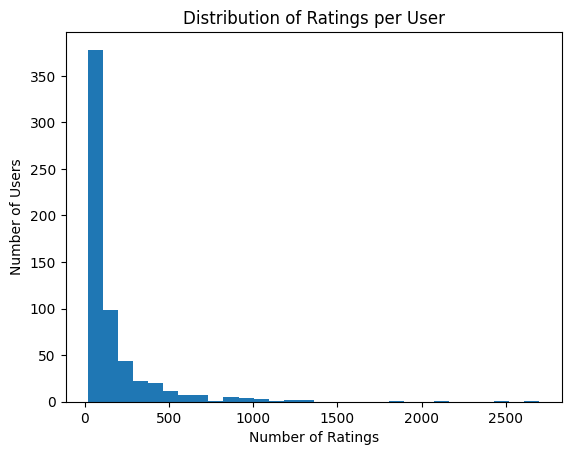

In [21]:
import matplotlib.pyplot as plt

plt.hist(ratings_per_user, bins=30)
plt.title("Distribution of Ratings per User")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Users")
plt.show()


In [22]:
ratings_per_user.head(5)


userId
414    2698
599    2478
474    2108
448    1864
274    1346
dtype: int64

In [23]:
mean_ratings = ratings_per_user.mean()
std_ratings = ratings_per_user.std()

z_score = (top_user - mean_ratings) / std_ratings

print(f"Top user Z-score: {round(z_score,2)}")


Top user Z-score: 9.4


In [24]:
ratings_per_user = ratings.groupby("userId").size().sort_values(ascending=False)

top_user_id = ratings_per_user.index[0]
top_user_count = ratings_per_user.iloc[0]

print(f"Top user ID: {top_user_id}")
print(f"Number of ratings: {top_user_count}")


Top user ID: 414
Number of ratings: 2698


In [25]:
ratings_movies = ratings.merge(movies, on="movieId", how="left")

top_user_ratings = ratings_movies[
    ratings_movies["userId"] == top_user_id
]


In [26]:
top_user_ratings["genres_list"] = top_user_ratings["genres"].str.split("|")


/var/folders/g7/ckk2ycjx2cv7qv6k9jx0kh8w0000gn/T/ipykernel_12690/2938272905.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_user_ratings["genres_list"] = top_user_ratings["genres"].str.split("|")


In [27]:
genre_counts = (
    top_user_ratings
    .explode("genres_list")
    .groupby("genres_list")
    .size()
    .sort_values(ascending=False)
)

genre_counts.head(10)


genres_list
Drama        1309
Comedy       1079
Action        668
Thriller      625
Romance       509
Adventure     457
Crime         416
Sci-Fi        323
Fantasy       226
Children      177
dtype: int64

In [28]:
genre_avg_rating = (
    top_user_ratings
    .explode("genres_list")
    .groupby("genres_list")["rating"]
    .mean()
    .sort_values(ascending=False)
)

genre_avg_rating.head(10)


genres_list
(no genres listed)    4.250000
Film-Noir             3.857143
War                   3.830645
Animation             3.786290
IMAX                  3.719298
Documentary           3.677419
Western               3.576923
Mystery               3.573333
Drama                 3.561497
Crime                 3.475962
Name: rating, dtype: float64

In [29]:
global_avg = ratings["rating"].mean()
print("Global average rating:", round(global_avg, 2))


Global average rating: 3.5


In [30]:
top_user_avg = top_user_ratings["rating"].mean()
print("Top user average rating:", round(top_user_avg, 2))


Top user average rating: 3.39


In [31]:
difference = top_user_avg - global_avg
print("Difference from global average:", round(difference, 2))


Difference from global average: -0.11


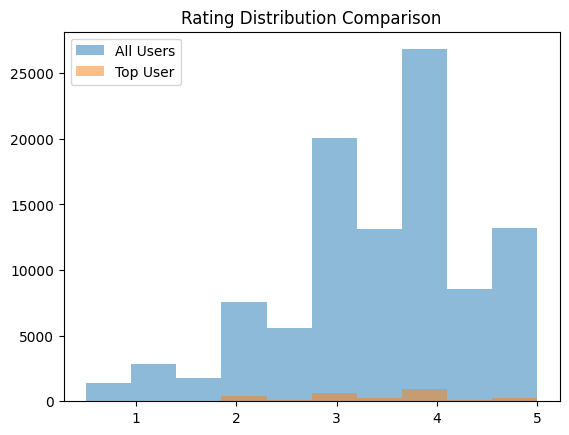

In [32]:
import matplotlib.pyplot as plt

plt.hist(ratings["rating"], bins=10, alpha=0.5, label="All Users")
plt.hist(top_user_ratings["rating"], bins=10, alpha=0.5, label="Top User")
plt.legend()
plt.title("Rating Distribution Comparison")
plt.show()


In [33]:
top_user_ratings["normalized_rating"] = (
    top_user_ratings["rating"] - top_user_avg
)


/var/folders/g7/ckk2ycjx2cv7qv6k9jx0kh8w0000gn/T/ipykernel_12690/1589780996.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_user_ratings["normalized_rating"] = (


In [34]:
movies["genre_count"] = movies["genres"].str.split("|").apply(len)

movies[["title", "genres", "genre_count"]].head()


,title,genres,genre_count
0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5
1,Jumanji (1995),Adventure|Children|Fantasy,3
2,Grumpier Old Men (1995),Comedy|Romance,2
3,Waiting to Exhale (1995),Comedy|Drama|Romance,3
4,Father of the Bride Part II (1995),Comedy,1


In [35]:
movies["genre_count"].value_counts().sort_index()


genre_count
1     2851
2     3218
3     2338
4      987
5      271
6       63
7       12
8        1
10       1
Name: count, dtype: int64

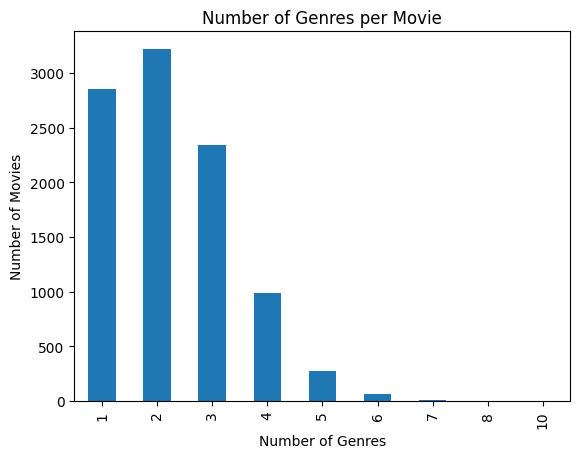

In [36]:
import matplotlib.pyplot as plt

movies["genre_count"].value_counts().sort_index().plot(kind="bar")
plt.title("Number of Genres per Movie")
plt.xlabel("Number of Genres")
plt.ylabel("Number of Movies")
plt.show()


In [37]:
max_genres = movies["genre_count"].max()

movies[movies["genre_count"] == max_genres][
    ["title", "genres", "genre_count"]
].head()


,title,genres,genre_count
7441,Rubber (2010),Action|Adventure|Comedy|Crime|Drama|Film-Noir|...,10


In [38]:
movies[movies["genres"] == "(no genres listed)"]


,movieId,title,genres,genre_count
8517,114335,La cravate (1957),(no genres listed),1
8684,122888,Ben-hur (2016),(no genres listed),1
8687,122896,Pirates of the Caribbean: Dead Men Tell No Tal...,(no genres listed),1
8782,129250,Superfast! (2015),(no genres listed),1
8836,132084,Let It Be Me (1995),(no genres listed),1
8902,134861,Trevor Noah: African American (2013),(no genres listed),1
9033,141131,Guardians (2016),(no genres listed),1
9053,141866,Green Room (2015),(no genres listed),1
9070,142456,The Brand New Testament (2015),(no genres listed),1
9091,143410,Hyena Road,(no genres listed),1
